In [1]:
import pandas as pd
import numpy as np
from time import process_time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from custom_functions import *
from custom_models import *

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalMaxPooling1D, Conv1D, Dropout, GlobalAveragePooling1D,LSTM, Bidirectional, TimeDistributed, Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

In [2]:
# For windows users (If exception in plot_model() function)
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

# Data prep

1. Load dataset

In [3]:
data = read_data("../Arabic Sentiment Identification/dataset/sentimentscore_with_weights.csv")
print(data.shape)

(12537, 13)


2. Preprocess and extract features

3.  Split into train and test

In [4]:
D_train, D_val =  train_test_split(data ,test_size=0.2, random_state=42)
D_train = D_train.reset_index()
D_val = D_val.reset_index()

4. Encode target variables (labels) to integers

In [5]:
class_label = "sentiment"

y_train, y_val = D_train[class_label].values.tolist(), D_val[class_label].values.tolist()

y_train = get_label_encoding(y_train)
y_val = get_label_encoding(y_val)

print(y_train.shape, y_val.shape)

Mapping:
{'NEG': 0, 'NEU': 1, 'POS': 2}
Mapping:
{'NEG': 0, 'NEU': 1, 'POS': 2}
(10029, 1) (2508, 1)


# Load Word Embeddings (Input 1)

1. Tokenize Tweets

In [6]:
text_label = "tweet_preprocessed"

# Tokenize Tweets
x_train = D_train[text_label].values.tolist()
x_val = D_val[text_label].values.tolist()

tokenizer, x_train_tokenized, x_val_tokenized = tokenize_text(data['tweet_preprocessed'].values.tolist(),
                                                               x_train, x_val)

print('x_train_tokenized:',len(x_train_tokenized),'\nx_val_tokenized:',len(x_val_tokenized),
      "\nTotal Vocab: ",len(tokenizer.word_counts))

x_train_tokenized: 10029 
x_val_tokenized: 2508 
Total Vocab:  48543


2. Pad tweets

In [7]:
# Pad Tweets
maximum_text_length = 50
padding_type = "post"
truncating_type = "post"

x_train_padded = pad_text_sequence(x_train_tokenized, maximum_text_length, padding_type, truncating_type)
x_val_padded = pad_text_sequence(x_val_tokenized, maximum_text_length, padding_type, truncating_type)

print('x_train_padded:',x_train_padded.shape,'\nx_val_padded',x_val_padded.shape)

x_train_padded: (10029, 50) 
x_val_padded (2508, 50)


3. Generate embedding matrix

In [12]:
# Load word embeddings from file
vocab = tokenizer.word_index
embedding_dimension = 300
embedding_dict_file = "../Arabic Sentiment Identification/word embeddings/mazajak_pretrained_300.pkl"

embedding_matrix = get_embedding_matrix(vocab, embedding_dict_file = embedding_dict_file, embedding_dimension = embedding_dimension)

# Validate embedding_matrix shape
print("\nTotal Vocab:",len(vocab), "\nEmbeddings:",embedding_matrix.shape[0] -1 )

Loading embeddings from:  ../Arabic Sentiment Identification/word embeddings/fasttext_pretrained_300.pkl

Total words processed: 34722
Words not found:  13823

Total Vocab: 48544 
Embeddings: 48544


# Load Sentiment Features (Input 2)

In [13]:
def get_sentiment_matrix(df):
    sentiment_matrix  = np.zeros((len(df), 6), dtype='float64')
    
    for i in range(len(df)):
        try:
            sentiment_matrix[i] = np.array([df['NEU_WEIGHTS'][i],df['POSNEG_WEIGHTS'][i], df['total_sentiment_score'][i], df['Pos_P'][i],
                                            df['Neg_P'][i], df['Neu_P'][i]], dtype='float64')
        except:
            print(i)
    return sentiment_matrix

In [14]:
sentiment_train = get_sentiment_matrix(D_train)
sentiment_val = get_sentiment_matrix(D_val)

print("Sentiment matrix (Train): {}\nSentiment matrix (Test): {}".format(sentiment_train.shape, sentiment_val.shape))

Sentiment matrix (Train): (10029, 4)
Sentiment matrix (Test): (2508, 4)


# Simple FFNN

In [15]:
i1 = Input(shape = (sentiment_train.shape[1]))
d1 = Dense(64, activation = "relu")(i1)
d2 = Dense(32, activation = "relu")(d1)
d3 = Dense(3, activation = "softmax")(d2)

model = Model(inputs = i1, outputs= d3)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

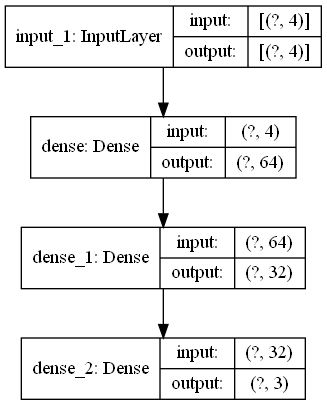

In [16]:
# m.summary()
plot_model(model, show_shapes=True)

In [17]:
h = model.fit(sentiment_train, y_train, epochs=10, validation_data = (sentiment_val, y_val))

Train on 10029 samples, validate on 2508 samples
Epoch 1/10
10029/10029 [==============================] - 3s 330us/sample - loss: 0.2961 - acc: 0.8881 - val_loss: 0.2003 - val_acc: 0.9254
Epoch 2/10
10029/10029 [==============================] - 1s 110us/sample - loss: 0.2221 - acc: 0.9173 - val_loss: 0.1967 - val_acc: 0.9278
Epoch 3/10
10029/10029 [==============================] - 1s 102us/sample - loss: 0.2193 - acc: 0.9172 - val_loss: 0.1965 - val_acc: 0.9254
Epoch 4/10
10029/10029 [==============================] - 1s 87us/sample - loss: 0.2152 - acc: 0.9199 - val_loss: 0.1938 - val_acc: 0.9242
Epoch 5/10
10029/10029 [==============================] - 1s 84us/sample - loss: 0.2155 - acc: 0.9190 - val_loss: 0.1940 - val_acc: 0.9274
Epoch 6/10
10029/10029 [==============================] - 1s 98us/sample - loss: 0.2131 - acc: 0.9203 - val_loss: 0.1950 - val_acc: 0.9294
Epoch 7/10
10029/10029 [==============================] - 1s 142us/sample - loss: 0.2125 - acc: 0.9210 - val_loss:

# Multi-Channel Bi-LSTM

In [18]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

#--------------------------------------------------------------------------------------------------------------------#

# Define model hyperparameters
input_length1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

input2 = sentiment_train
input_length2 = input2.shape[1]

output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length1,"x",embedding_dimension)
print('Shape of Input layer 1: ',len(x_train),"x",embedding_dimension)
print('Shape of Input layer 2: ',len(x_train),"x",input_length2)

print("Output classes: ",output_dimension)
#--------------------------------------------------------------------------------------------------------------------#

# Define Input Channel 1

Input_layer1 = Input(shape = (input_length1,))
Embedding_layer1 = Embedding(input_length = input_length1, input_dim = embedding_vocab1, output_dim = embedding_dimension1,
                             weights = [embedding_matrix], trainable = False)(Input_layer1)

LSTM_layer1 = Bidirectional(LSTM(128, return_sequences = True))(Embedding_layer1)
Max_Pool_1 = GlobalMaxPooling1D()(LSTM_layer1)
Dense1 = Dense(64, activation = "relu")(Max_Pool_1)
dropout_Dense1 = Dropout(0.25)(Dense1)

# Input Channel 2
Input_layer2 = Input(shape= (input_length2,))
# Dense2 = Dense(64, activation = "relu")(Input_layer2)

# Concatentate Channels
Concat_layer= concatenate([dropout_Dense1, Input_layer2])

# Define output layer
Output_layer = Dense(output_dimension, activation = "softmax")(Concat_layer)


# Compile model
model = Model(inputs = [Input_layer1, Input_layer2], outputs = Output_layer)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics= ["acc"])

Shape of each Input Sentence:  50 x 300
Shape of Input layer 1:  10029 x 300
Shape of Input layer 2:  10029 x 4
Output classes:  3


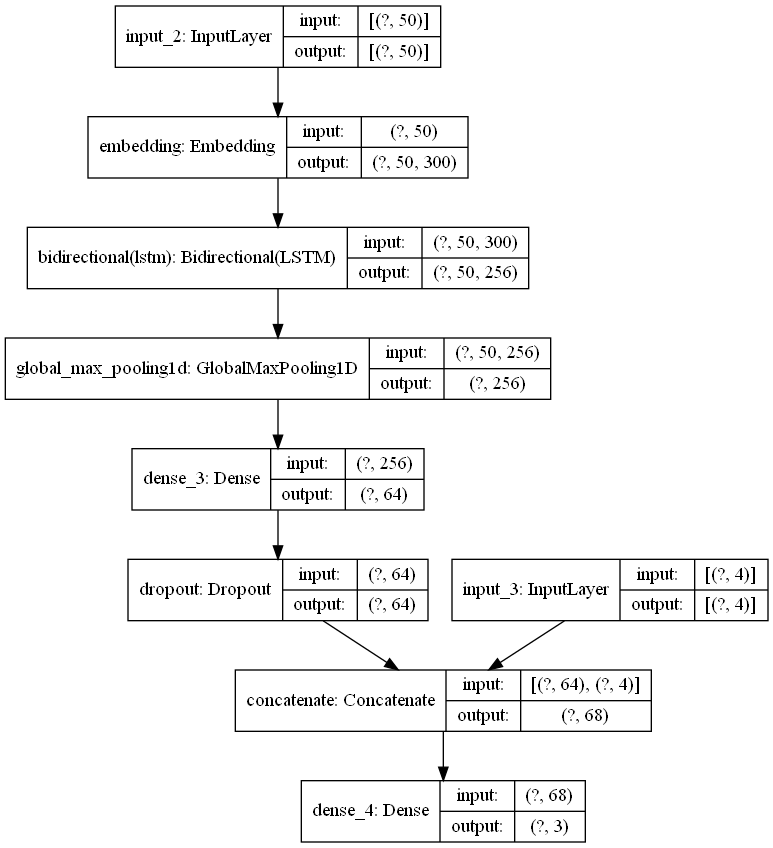

In [19]:
# model.summary()
plot_model(model, show_shapes=True)

In [ ]:
model_history = model.fit([x_train_padded, sentiment_train],
                         y_train, epochs=10, batch_size= 128, verbose=1, validation_data = ([x_val_padded,sentiment_val],
                                                                                            y_val))

Train on 10029 samples, validate on 2508 samples
Epoch 1/10
10029/10029 [==============================] - 78s 8ms/sample - loss: 0.8193 - acc: 0.6886 - val_loss: 0.4831 - val_acc: 0.7998
Epoch 2/10
10029/10029 [==============================] - 66s 7ms/sample - loss: 0.4357 - acc: 0.8330 - val_loss: 0.3342 - val_acc: 0.8951
Epoch 3/10
10029/10029 [==============================] - 66s 7ms/sample - loss: 0.3231 - acc: 0.8948 - val_loss: 0.2684 - val_acc: 0.9183
Epoch 4/10
10029/10029 [==============================] - 73s 7ms/sample - loss: 0.2681 - acc: 0.9203 - val_loss: 0.2564 - val_acc: 0.9167
Epoch 5/10
10029/10029 [==============================] - 75s 7ms/sample - loss: 0.2333 - acc: 0.9313 - val_loss: 0.2273 - val_acc: 0.9330
Epoch 6/10
 9984/10029 [============================>.] - ETA: 0s - loss: 0.2081 - acc: 0.9404

6. Evaluate Model

In [ ]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded,sentiment_val]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

In [ ]:
# save model

# Multi-Channel CNN

In [ ]:
# Input 1
input1 = embedding_matrix
input_len1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

# Input 2
input2 = sentiment_train
input_len2 = sentiment_train.shape[1]

# Output
output_dim = len(np.unique(y_train))

# Input Channel 1
i1 = Input(shape = (input_len1, ))
e1 = Embedding(input_length=input_len1, input_dim=embedding_vocab1, output_dim = embedding_dimension1,
               weights = [input1], trainable = False)(i1)
c1 = Conv1D(filters = 256, kernel_size=3, padding = "same", activation="relu")(e1)
gmp = GlobalMaxPooling1D()(c1)
c1_do = Dropout(0.3)(gmp)
# max_pool1 = MaxPooling1D(pool_size=3)(c1_do)


d1 = Dense(64, activation="relu")(c1_do)

# Input Channel 2
i2 = Input(shape = (input_len2, ))
# d2 = Dense(64, activation = "relu")(i2)

# Merge Channels
merged = concatenate([d1,i2])

#output
output = Dense(output_dim, activation = "softmax")(merged)


# Compile
model = Model(inputs = [i1, i2], outputs = output)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model_history = model.fit([x_train_padded, sentiment_train], y_train, epochs = 10, batch_size = 64,
                                  validation_data = ([x_val_padded, sentiment_val],y_val))

In [ ]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded,sentiment_val]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

# Multi-Channel CNN-BiLSTM

In [ ]:
# Input 1
input1 = embedding_matrix
input_len1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

# Input 2
input2 = sentiment_train
input_len2 = sentiment_train.shape[1]

# Output
output_dim = len(np.unique(y_train))

#--------------------------------------------------------------------------------------------------------------------#

# Input Channel 1
i1 = Input(shape = (input_len1, ))
e1 = Embedding(input_length=input_len1, input_dim=embedding_vocab1, output_dim = embedding_dimension1,
               weights = [input1], trainable = False)(i1)
c1 = Conv1D(filters = 256, kernel_size=3, padding = "same", activation="relu")(e1)
c1_do = Dropout(0.3)(c1)
max_pool1 = MaxPooling1D(pool_size=3)(c1_do)

b1 = Bidirectional(LSTM(128, dropout = 0.3, return_sequences = True, ))(max_pool1)
gmp1 = GlobalMaxPooling1D()(b1)

d1 = Dense(64, activation = "relu")(gmp1)

# Input Channel 2
i2 = Input(shape = (input_len2, ))
# d2 = Dense(64, activation = "relu")(i2)

# Merge channels
merge = concatenate([d1, i2])

# Output layer
output = Dense(output_dim, activation = "softmax")(merge)


#---------------------------------------------------------------------------------------------------------------------#

# Compile
model = Model(inputs = [i1, i2], outputs = output)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model_history = model.fit([x_train_padded, sentiment_train], y_train, epochs=10, verbose = 1, batch_size=64,
                         validation_data=([x_val_padded,sentiment_val], y_val))

In [ ]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded,sentiment_val]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

# Multi-Channel CNN-BiLSTM with Attention